In [1]:
from sympy import *
from IPython.display import display

def quality_evaluation(starting_tier, target_tier, max_qual, base_prod, prods, quals, debug = False, gradients = False):
    h = 5
    m = target_tier
    #h, m = symbols("h, m", integer=True, positive=True, nonzero=True)
    T4qual = Rational(1, 40) * (Rational(5, 2) if max_qual else Rational(1, 1)) # type: ignore
    T4prod = Rational(1, 10) * (Rational(5, 2) if max_qual else Rational(1, 1)) # type: ignore
    q_cv, p_cv, q_rv, p_rv = quals * T4qual, (1.5 if base_prod else 1.0) + prods * T4prod, 4 * T4qual, 1 # type: ignore
    d_0v = [0, 0, 0, 0, 0]
    d_0v[starting_tier] = 1

    q_c, p_c, q_r, p_r = symbols("q_c, p_c, q_r, p_r", real=True, positive=True)
    q_cs = Matrix([[*symbols(", ".join("q_{c_"+str(i)+"}" for i in range(1, h+1)), real=True, positive=True)]])
    p_cs = Matrix([[*symbols(", ".join("p_{c_"+str(i)+"}" for i in range(1, h+1)), real=True, positive=True)]])
    q_rs = Matrix([[*symbols(", ".join("q_{r_"+str(i)+"}" for i in range(1, h+1)), real=True, positive=True)]])
    p_rs = Matrix([[*symbols(", ".join("p_{r_"+str(i)+"}" for i in range(1, h+1)), real=True, positive=True)]])

    #display(q_cs)

    d_0 = Matrix([[*symbols(", ".join("d_0"+str(i) for i in range(1, h+1)), integer=True, positive=True, nonzero=True)]]).T

    l = Matrix([[1]*(m-1)+[0]*(h+1-m)])
    #L = diag(*l)

    full_subs_list = [(x, q_cv) for x in q_cs] + [(x, p_cv) for x in p_cs] + [(x, q_rv) for x in q_rs] + [(x, p_rv) for x in p_rs] + [(k, v) for k, v in zip(d_0, d_0v)]

    i, j, r = symbols("i, j, k", integer=True)

    #C_0f = Piecewise((0, i>j),(p_c-p_c*q_c*(Rational(10, 9) - 10**(1+i-h)/9), Eq(i,j)),(p_c*q_c/(10**(j-i-1)), i<j))
    #R_0f = Piecewise((0, i>j),(p_r/4-p_r/4*q_r*(Rational(10, 9) - 10**(1+i-h)/9), Eq(i,j)),(p_r*q_r/(4*10**(j-i-1)), i<j))
    Cf = Piecewise((0, i>j),(p_c-p_c*q_c*(Rational(10, 9) - 10**(2+i-h)/9), Eq(i,j)),(p_c*q_c/(10**(j-i-1)), i<j))
    Rf = Piecewise((0, i>j),(p_r/4-p_r/4*q_r*(Rational(10, 9) - 10**(2+i-h)/9), Eq(i,j)),(p_r*q_r/(4*10**(j-i-1)), i<j))

    #Cf = piecewise_fold(Piecewise((C_0f, i<m-1),(0, (i>=m-1) & Ne(i,j)),(1, (i>=m-1) & Eq(i,j))))
    #Rf = piecewise_fold(Piecewise((R_0f, i<m-1),(0, (i>=m-1) & Ne(i,j)),(1, (i>=m-1) & Eq(i,j))))

    def apply_column_based_effects(L):
        return Matrix([[L[:,iv].subs([(q_c, q_cs[iv]), (p_c, p_cs[iv]), (q_r, q_rs[iv]), (p_r, p_rs[iv])]) for iv in range(L.shape[1])]])

    C = FunctionMatrix(h, h, Lambda((j, i), Cf)).as_explicit()
    R = FunctionMatrix(h, h, Lambda((j, i), Rf)).as_explicit()
    C = apply_column_based_effects(C)
    R = apply_column_based_effects(R)

    if debug:
        display(C.subs(full_subs_list))
        display(R.subs(full_subs_list))

    #CR = simplify(C * R)
    CR = (C * R)
    T = CR * diag(*l) + eye(h) - diag(*l)

    if debug:
        display(T.subs(full_subs_list))

    def L_eigenvectors(L):
        eigenvectors = []
        for r in range(1, L.shape[0]+1):
            L_minus = L - L[r-1,r-1] * eye(L.shape[0])
            eigenvector = [0] * (r - 1) + [1]
            for jv in range(r+1, L.shape[0]+1):
                s = 0
                for iv in range(1, jv):
                    s += L_minus[jv-1,iv-1] * eigenvector[iv-1]
                if L_minus[jv-1,jv-1]==0:
                    assert s==0
                    eigenvector.append(0)
                else:   
                    eigenvector.append(-s/L_minus[jv-1,jv-1])
            eigenvectors.append(eigenvector)
        return Matrix(eigenvectors).T

    def L_inverse(L):
        columns = []
        for r in range(1, L.shape[0]+1):
            column = [0] * (r - 1) + [1 / L[r-1,r-1]]
            for jv in range(r+1, L.shape[0]+1):
                s = 0
                for iv in range(1, jv):
                    s += L[jv-1,iv-1] * column[iv-1]
                column.append(-s/L[jv-1,jv-1])
            columns.append(column)
        return Matrix(columns).T

    def D_inf_val(D):
        return diag(*[1 if D[iv,iv]==1 else 0 for iv in range(D.shape[0])])

    def D_inf_sum(D):
        #return simplify(diag(*[0 if D[iv,iv]==1 else 1/(1-D[iv,iv]) for iv in range(D.shape[0])]))
        return diag(*[0 if D[iv,iv]==1 else 1/(1-D[iv,iv]) for iv in range(D.shape[0])])

    D = diag(*Matrix.diagonal(T))
    #E = simplify(L_eigenvectors(CR))
    #E_inv = simplify(L_inverse(E))
    E = L_eigenvectors(T)
    E_inv = L_inverse(E)

    #display(E)
    #display(D)
    #display(E_inv)

    d_inf = E * D_inf_val(D) * E_inv * C * d_0
    #display(d_inf)

    L = (E * D_inf_sum(D) * E_inv * C * d_0)


    #display(D_inf_sum(D))

    #subs_list = [(q_c, q_cv), (p_c, p_cv), (q_r, q_rv), (p_r, p_rv)] + [(k, v) for k, v in zip(d_0, d_0v)]

    #display(d_inf.subs(subs_list))
    #print(float(1/d_inf.subs(subs_list)[m-1]))
    #display(Lc.subs(subs_list))
    #print(float(Lc.subs(subs_list)))
    #display(Lr.subs(subs_list))
    #print(float(Lr.subs(subs_list)))

    if debug:
        print("========================================")
        display(d_inf.subs(full_subs_list))
        print(float(1/d_inf.subs(full_subs_list)[m-1]))
        display(L.subs(full_subs_list))
        print(float((l * L)[0,0].subs(full_subs_list)))
    result = float(1/d_inf.subs(full_subs_list)[m-1])

    #derivatives = [q_c, p_c, q_r, p_r]
    full_derivatives = [*q_cs] + [*p_cs] + [*q_rs] + [*p_rs]
    full_derivatives_bundle = list(zip([*q_cs], list(range(q_cs.shape[1])))) + list(zip([*p_cs], list(range(p_cs.shape[1])))) + \
                                         list(zip([*q_rs], list(range(q_rs.shape[1])))) + list(zip([*p_rs], list(range(p_rs.shape[1]))))
    if gradients:
        for x, g in zip(full_derivatives, [d_inf.diff(dt)[m-1,0] / (L+d_0)[i,0] for dt, i in full_derivatives_bundle]):
            print("========================================")
            print(x)
            print(float(g.subs(full_subs_list)))
    
    return result

In [ ]:
quality_evaluation(0, 5, False, False, 0, 4, debug=True)

In [ ]:
quality_evaluation(0, 5, False, False, 4, 0, debug=True)

In [ ]:
output_dump: str = ""
for starting_tier in range(0, 4):
    for target_tier in range(starting_tier+1, 5+1):
        for max_qual in [False, True]:
            for max_assembler_modules in [4, 5]:
                for base_prod in [False, True]:
                    best_module_setup_quals = 0
                    best_module_setup_prods = 0
                    best_result = 10000000000000000000
                    for prods in range(max_assembler_modules+1):
                        quals = max_assembler_modules-prods

                        result = quality_evaluation(starting_tier, target_tier, max_qual, base_prod, prods, quals)

                        if result < best_result:
                            best_result = result
                            best_module_setup_quals = quals
                            best_module_setup_prods = prods
                        
                    print(str(starting_tier+1)+"->"+str(target_tier)+(" with max qual " if max_qual else " at base qual ")+" with "+str(max_assembler_modules)+" modules and "+str(50 if base_prod else 0)+" base productivty:\n"+\
                          "Proper setup is: "+str(best_module_setup_prods)+" productivity modules and "+str(best_module_setup_quals)+" quality modules, resulting in "+str(best_result)+" inputs per 1 output.")
                    output_dump += str(starting_tier+1)+", "+str(target_tier)+", "+str((5 if max_qual else 1))+", "+str(max_assembler_modules)+", "+str((50 if base_prod else 0))+", "+str(best_module_setup_prods)+", "+str(best_module_setup_quals)+", "+str(best_result)+"\n"

In [ ]:
print(output_dump)

In [ ]:
[*q_cs]

In [ ]:
list(range(1, 5))

In [1]:
#newmethod
from sympy import *
from sympy.stats import *
from IPython.display import display


kappa = 5
m = 6

q_ms = Matrix([[*symbols(", ".join("q_{m_"+str(i)+"}" for i in range(1, kappa+1)), rational=True, positive=True)]])
q_rs = Matrix([[*symbols(", ".join("q_{r_"+str(i)+"}" for i in range(1, kappa+1)), rational=True, positive=True)]])
p_ms = Matrix([[*symbols(", ".join("p_{m_"+str(i)+"}" for i in range(1, kappa+1)), rational=True, positive=True)]])
p_rs = Matrix([[*symbols(", ".join("p_{r_"+str(i)+"}" for i in range(1, kappa+1)), rational=True, positive=True)]])

MRVs = [FiniteRV('M'+str(i), {j: 1-q_ms[i-1]*(Rational(10,9) - Rational(Pow(10,(1-(kappa-i))),9)) if i==j else q_ms[i-1]*Rational(1,10**(j-i-1)) for j in range(i, kappa+1)}) for i in range(1, kappa+1)] # type: ignore
#RRVs = [FiniteRV('R'+str(i), dict([(0, Rational(3,4))]+[(j, Rational(1,4) * (1-q_rs[i-1]*(Rational(10,9) - Rational(Pow(10,(1-(kappa-i))),9)) if i==j else q_rs[i-1]*Rational(1,10**(j-i-1)))) for j in range(i, kappa+1)])) for i in range(1, kappa+1)] # type: ignore
RRVs  = [FiniteRV('R'+str(i), {j: 1-q_rs[i-1]*(Rational(10,9) - Rational(Pow(10,(1-(kappa-i))),9)) if i==j else q_rs[i-1]*Rational(1,10**(j-i-1)) for j in range(i, kappa+1)}) for i in range(1, kappa+1)] # type: ignore

es = [eye(kappa).col(i) for i in range(kappa)]

binom = Binomial('B', m, Rational(1, 4))

#special_subs = [(q_rs[0, i], 4 * T4qual) for i in range(kappa)] + [(p_rs[0, i], 1) for i in range(kappa)] + [(q_ms[0, i], 5 * T4qual) for i in range(kappa)] + [(p_ms[0, i], 1 + Rational(1, 2)) for i in range(kappa-1)]+[(p_ms[0, kappa-1], 1 + Rational(1, 2) + 5 * T4prod)]

N_i_moment_symbol_cache = {}
def N_i_moment_symbols(n: int):
    if not n in N_i_moment_symbol_cache.keys():
        N_i_moment_symbol_cache[n] = [Matrix([*symbols(", ".join("(N_{"+str(i)+"}^{"+str(n)+"})_"+str(j) for j in range(1, kappa+1)), rational=True)]) for i in range(1, kappa+1)]

    return N_i_moment_symbol_cache[n]

def N_i_moment_n_eq(i: int, n: int):
    moment_symbols = N_i_moment_symbols(n)
    s = Matrix.zeros(kappa, 1)

    for j in range(1, kappa):
        r = Matrix.zeros(kappa, 1)
        for k in range(1, kappa+1):
            rv = P(Eq(RRVs[j-1], k)) * moment_symbols[k-1]
            if r == Matrix.zeros(kappa, 1):
                r = rv
            else:
                r += rv

        s += P(Eq(MRVs[i-1], j)) * Pow(p_rs[j-1], n) * r
    
    s *= Pow(p_ms[i-1], n) * moment(binom, n, 0) / Pow(m, n) # type: ignore
    
    s += Pow(p_ms[i-1], n) * P(Eq(MRVs[i-1], kappa)) * es[kappa-1]

    return [Eq(symb, solve(Eq(symb, s_v), symb)[0]) for symb, s_v in zip(moment_symbols[i-1], s)]

def input_N_i_moment_n_eq(i: int, n: int):
    moment_symbols = N_i_moment_symbols(n)
    s = Matrix.zeros(kappa, 1)

    if i==kappa:
        s = es[kappa-1]

    else:
        for j in range(1, kappa):
            r = Matrix.zeros(kappa, 1)
            for k in range(1, kappa+1):
                rv = P(Eq(RRVs[j-1], k)) * moment_symbols[k-1]
                if r == Matrix.zeros(kappa, 1):
                    r = rv
                else:
                    r += rv

            s += P(Eq(MRVs[i-1], j)) * Pow(p_rs[j-1], n) * r
        
        s *= Pow(p_ms[i-1], n) * moment(binom, n, 0) / Pow(m, n) # type: ignore

    return [Eq(symb, solve(Eq(symb, s_v), symb)[0]) for symb, s_v in zip(moment_symbols[i-1], s)]

def N_moment_n_closed_forms(n: int):
    eqs = [N_i_moment_n_eq(i, n) for i in range(1, kappa+1)]
    solutions = {eqs[-1][-1].lhs: eqs[-1][-1].rhs}
    for i in range(kappa-1, -1, -1):
        for j in range(kappa-1, -1, -1):
            solutions[eqs[i][j].lhs] = eqs[i][j].rhs.subs(solutions)

    out = {}
    for k, v in solutions.items():
        if int(str(k)[-1])==kappa:
            out[k] = v
    return out

def input_N_moment_n_closed_forms(n: int):
    eqs = [input_N_i_moment_n_eq(i, n) for i in range(1, kappa+1)]
    solutions = {eqs[-1][-1].lhs: eqs[-1][-1].rhs}
    for i in range(kappa-1, -1, -1):
        for j in range(kappa-1, -1, -1):
            solutions[eqs[i][j].lhs] = eqs[i][j].rhs.subs(solutions)

    out = {}
    for k, v in solutions.items():
        if int(str(k)[-1])==kappa:
            out[k] = v
    return out
    
#display(N_i_moment_symbols(2, 5))
symbs = set()
for N_i_symbs in N_i_moment_symbols(2):
    symbs.update(N_i_symbs.free_symbols)
print(symbs)
for equation in input_N_i_moment_n_eq(3, 1):
    display(equation)
    #print(solve(equation, symbs)[0])
print("==========================")
valuable_first_moments = N_moment_n_closed_forms(1)
#for k, fm in valuable_first_moments.items():
#    display(Eq(k, fm))
valuable_second_moments = N_moment_n_closed_forms(2)
#for k, sm in valuable_second_moments.items():
#    display(Eq(k, sm))
input_valuable_first_moments = input_N_moment_n_closed_forms(1)
input_valuable_second_moments = input_N_moment_n_closed_forms(2)

{(N_{4}^{2})_5, (N_{3}^{2})_1, (N_{3}^{2})_3, (N_{1}^{2})_3, (N_{2}^{2})_2, (N_{1}^{2})_1, (N_{2}^{2})_5, (N_{5}^{2})_4, (N_{5}^{2})_5, (N_{4}^{2})_1, (N_{1}^{2})_4, (N_{1}^{2})_5, (N_{1}^{2})_2, (N_{5}^{2})_1, (N_{4}^{2})_3, (N_{3}^{2})_4, (N_{2}^{2})_1, (N_{2}^{2})_4, (N_{4}^{2})_4, (N_{5}^{2})_2, (N_{5}^{2})_3, (N_{3}^{2})_5, (N_{4}^{2})_2, (N_{3}^{2})_2, (N_{2}^{2})_3}


Eq((N_{3}^{1})_1, p_{m_3}*(-110*(N_{4}^{1})_1*p_{r_3}*q_{m_3}*q_{r_3} + 100*(N_{4}^{1})_1*p_{r_3}*q_{r_3} - 100*(N_{4}^{1})_1*p_{r_4}*q_{m_3}*q_{r_4} + 100*(N_{4}^{1})_1*p_{r_4}*q_{m_3} - 11*(N_{5}^{1})_1*p_{r_3}*q_{m_3}*q_{r_3} + 10*(N_{5}^{1})_1*p_{r_3}*q_{r_3} + 100*(N_{5}^{1})_1*p_{r_4}*q_{m_3}*q_{r_4})/(-121*p_{m_3}*p_{r_3}*q_{m_3}*q_{r_3} + 110*p_{m_3}*p_{r_3}*q_{m_3} + 110*p_{m_3}*p_{r_3}*q_{r_3} - 100*p_{m_3}*p_{r_3} + 400))

Eq((N_{3}^{1})_2, p_{m_3}*(-110*(N_{4}^{1})_2*p_{r_3}*q_{m_3}*q_{r_3} + 100*(N_{4}^{1})_2*p_{r_3}*q_{r_3} - 100*(N_{4}^{1})_2*p_{r_4}*q_{m_3}*q_{r_4} + 100*(N_{4}^{1})_2*p_{r_4}*q_{m_3} - 11*(N_{5}^{1})_2*p_{r_3}*q_{m_3}*q_{r_3} + 10*(N_{5}^{1})_2*p_{r_3}*q_{r_3} + 100*(N_{5}^{1})_2*p_{r_4}*q_{m_3}*q_{r_4})/(-121*p_{m_3}*p_{r_3}*q_{m_3}*q_{r_3} + 110*p_{m_3}*p_{r_3}*q_{m_3} + 110*p_{m_3}*p_{r_3}*q_{r_3} - 100*p_{m_3}*p_{r_3} + 400))

Eq((N_{3}^{1})_3, p_{m_3}*(-110*(N_{4}^{1})_3*p_{r_3}*q_{m_3}*q_{r_3} + 100*(N_{4}^{1})_3*p_{r_3}*q_{r_3} - 100*(N_{4}^{1})_3*p_{r_4}*q_{m_3}*q_{r_4} + 100*(N_{4}^{1})_3*p_{r_4}*q_{m_3} - 11*(N_{5}^{1})_3*p_{r_3}*q_{m_3}*q_{r_3} + 10*(N_{5}^{1})_3*p_{r_3}*q_{r_3} + 100*(N_{5}^{1})_3*p_{r_4}*q_{m_3}*q_{r_4})/(-121*p_{m_3}*p_{r_3}*q_{m_3}*q_{r_3} + 110*p_{m_3}*p_{r_3}*q_{m_3} + 110*p_{m_3}*p_{r_3}*q_{r_3} - 100*p_{m_3}*p_{r_3} + 400))

Eq((N_{3}^{1})_4, p_{m_3}*(-110*(N_{4}^{1})_4*p_{r_3}*q_{m_3}*q_{r_3} + 100*(N_{4}^{1})_4*p_{r_3}*q_{r_3} - 100*(N_{4}^{1})_4*p_{r_4}*q_{m_3}*q_{r_4} + 100*(N_{4}^{1})_4*p_{r_4}*q_{m_3} - 11*(N_{5}^{1})_4*p_{r_3}*q_{m_3}*q_{r_3} + 10*(N_{5}^{1})_4*p_{r_3}*q_{r_3} + 100*(N_{5}^{1})_4*p_{r_4}*q_{m_3}*q_{r_4})/(-121*p_{m_3}*p_{r_3}*q_{m_3}*q_{r_3} + 110*p_{m_3}*p_{r_3}*q_{m_3} + 110*p_{m_3}*p_{r_3}*q_{r_3} - 100*p_{m_3}*p_{r_3} + 400))

Eq((N_{3}^{1})_5, p_{m_3}*(-110*(N_{4}^{1})_5*p_{r_3}*q_{m_3}*q_{r_3} + 100*(N_{4}^{1})_5*p_{r_3}*q_{r_3} - 100*(N_{4}^{1})_5*p_{r_4}*q_{m_3}*q_{r_4} + 100*(N_{4}^{1})_5*p_{r_4}*q_{m_3} - 11*(N_{5}^{1})_5*p_{r_3}*q_{m_3}*q_{r_3} + 10*(N_{5}^{1})_5*p_{r_3}*q_{r_3} + 100*(N_{5}^{1})_5*p_{r_4}*q_{m_3}*q_{r_4})/(-121*p_{m_3}*p_{r_3}*q_{m_3}*q_{r_3} + 110*p_{m_3}*p_{r_3}*q_{m_3} + 110*p_{m_3}*p_{r_3}*q_{r_3} - 100*p_{m_3}*p_{r_3} + 400))

In [2]:
import itertools

T4qual = Rational(1, 40) * Rational(25, 10) # type: ignore
T4prod = Rational(10, 100) * Rational(25, 10) # type: ignore

def calculate_best_setup(mod_count: int, base_prod: Rational):
    global_subs = [(q_rs[0, i], 4 * T4qual) for i in range(kappa)] + [(p_rs[0, i], 1) for i in range(kappa)]
    reduced = [vfm.subs(global_subs) for vfm in valuable_first_moments.values()]
    reduced_variances = [vsm.subs(global_subs) for vsm in valuable_second_moments.values()]
    best_setups = []
    best_module_values = []
    for i in range(0, kappa):
        best = None
        best_val = 0
        for pc in range(0, mod_count+1):
            val = reduced[i].subs([(p_ms[0, kappa - i - 1], T4prod * pc + base_prod + 1), (q_ms[0, kappa - i - 1], (mod_count - pc) * T4qual)])
            if val >= best_val:
                best = (pc, mod_count - pc)
                best_val = val

        assert not best is None
        reduced = [r.subs([(p_ms[0, kappa - i - 1], T4prod * best[0] + base_prod + 1), (q_ms[0, kappa - i - 1], best[1] * T4qual)]) for r in reduced]
        reduced_variances = [r.subs([(p_ms[0, kappa - i - 1], T4prod * best[0] + base_prod + 1), (q_ms[0, kappa - i - 1], best[1] * T4qual)]) for r in reduced_variances]
        best_setups.insert(0, best)
        best_module_values.insert(0, (T4prod * best[0] + base_prod + 1, best[1] * T4qual))
    
    return reduced, reduced_variances, best_setups, best_module_values

def calculate_best_input_setup(mod_count: int, base_prod: Rational):
    global_subs = [(q_rs[0, i], 4 * T4qual) for i in range(kappa)] + [(p_rs[0, i], 1) for i in range(kappa)]
    reduced = [vfm.subs(global_subs) for vfm in input_valuable_first_moments.values()]
    reduced_variances = [vsm.subs(global_subs) for vsm in input_valuable_second_moments.values()]
    best_setups = []
    best_module_values = []
    for i in range(0, kappa):
        best = None
        best_val = 0
        for pc in range(0, mod_count+1):
            val = reduced[i].subs([(p_ms[0, kappa - i - 1], T4prod * pc + base_prod + 1), (q_ms[0, kappa - i - 1], (mod_count - pc) * T4qual)])
            if val >= best_val:
                best = (pc, mod_count - pc)
                best_val = val

        assert not best is None
        reduced = [r.subs([(p_ms[0, kappa - i - 1], T4prod * best[0] + base_prod + 1), (q_ms[0, kappa - i - 1], best[1] * T4qual)]) for r in reduced]
        reduced_variances = [r.subs([(p_ms[0, kappa - i - 1], T4prod * best[0] + base_prod + 1), (q_ms[0, kappa - i - 1], best[1] * T4qual)]) for r in reduced_variances]
        best_setups.insert(0, best)
        best_module_values.insert(0, (T4prod * best[0] + base_prod + 1, best[1] * T4qual))
    
    return reduced, reduced_variances, best_setups, best_module_values

calculate_best_input_setup(4, Rational(1, 2))

([1, 5/17, 67/595, 33976809/757686209, 1233790001023257/68935493959315457],
 [1,
  75/287,
  15555/169043,
  1115143105311/37715521308871,
  8480132092185958497267/841641469965390413993387],
 [(3, 1), (3, 1), (4, 0), (4, 0), (4, 0)],
 [(9/4, 1/16), (9/4, 1/16), (5/2, 0), (5/2, 0), (5/2, 0)])

In [54]:
float(list(valuable_first_moments.values())[-1].subs([(q_rs[0, i], 4 * T4qual) for i in range(kappa)] + [(p_rs[0, i], 1) for i in range(kappa)] + [(q_ms[0, i], 5 * T4qual) for i in range(kappa)] + [(p_ms[0, i], 1 + Rational(1, 2)) for i in range(kappa-1)]+[(p_ms[0, kappa-1], 1 + Rational(1, 2) + 5 * T4prod)]))

0.47091418144393127

In [56]:
5 * T4qual

5/16

In [74]:
for v in list(input_valuable_first_moments.values())[:2]:
    display(v)

1

(-p_{m_4}*p_{r_4}*q_{m_4}*q_{r_4} + p_{m_4}*p_{r_4}*q_{r_4} + 4)/(-p_{m_4}*p_{r_4}*q_{m_4}*q_{r_4} + p_{m_4}*p_{r_4}*q_{m_4} + p_{m_4}*p_{r_4}*q_{r_4} - p_{m_4}*p_{r_4} + 4)

In [22]:
moment(binom, 1, 0) / m

1/4

In [ ]:
solve(Eq(q_ms[0], 1), [q_ms[0], q_ms[1]])

In [ ]:
A = MatrixSymbol('A', 2, 2)

# Define a 2x2 zero matrix
zero_matrix = Matrix.zeros(2, 2)

display(A[0, 1])

# Create a list of scalar equations for each element of the matrix A
equations = [Eq(A[i, j], zero_matrix[i, j]) for i in range(2) for j in range(2)]

display(equations)

# Solve the system of equations for A's elements
solution = solve(equations)

# Print the solution
print(solution)

In [22]:
from typing import Any
from sympy import *
from sympy.stats import *
from IPython.display import display


quality_count = 5
craft_sequence: list[tuple[int, Rational, bool]] = [(5, Rational(1, 2), True), (4, Rational(0, 2), False), (4, Rational(0, 2), False)]#, (4, Rational(0, 2), False)]

qual_module_effect: Rational = Rational(1, 40) * Rational(25, 10) # type: ignore
prod_module_effect: Rational = Rational(10, 100) * Rational(25, 10) # type: ignore
recycling_recovery: Rational = Rational(1, 4)

craft_setup_vars: list[list[Symbol]] = [[Symbol('m_'+str(i)+"_"+str(j), integer=True, nonnegative=True) for j in range(quality_count)] for i in range(len(craft_sequence))] #prefered: quality

def upgrade_matrix(qualities: Any | list[Any]) -> MutableDenseMatrix:
    if not isinstance(qualities, list):
        qualities = [qualities] * quality_count
    return Matrix([[0 if i > j else (1 - qualities[i] * Rational(10, 9) + qualities[i] * (Rational(1, 9 * (10 ** (-2 - i + quality_count))) if 2 + i - quality_count < 0 else Rational(10 ** (2 + i - quality_count), 9)) if i == j else qualities[i] * Rational(1, 10 ** (j - i - 1))) for i in range(quality_count)] for j in range(quality_count)])

def recycle_step(sequence_point: int):
    recycle_upgrades = upgrade_matrix(4 * qual_module_effect) # type: ignore
    #display(recycle_upgrades)
    crafting_upgrades = upgrade_matrix([v * qual_module_effect for v in craft_setup_vars[sequence_point]]) # type: ignore
    #display(crafting_upgrades)
    total_effect = recycling_recovery * recycle_upgrades * crafting_upgrades * diag(*[(prod_module_effect * (craft_sequence[sequence_point][0] - v) if craft_sequence[sequence_point][2] else 0) + craft_sequence[sequence_point][1] + 1 for v in craft_setup_vars[sequence_point]]) # type: ignore
    #display(total_effect)
    return total_effect

def recycling_eliminations(sequence_point: int):
    single_step = recycle_step(sequence_point)
    #display(single_step[:, quality_level-1])
    recoveries = single_step.diagonal()
    single_step = single_step - diag(*recoveries)
    #display(single_step[:, quality_level] / (1 - recovery))
    return single_step * diag(*((-1 * recoveries).applyfunc(lambda x: (1 + x)**(-1))))

def crafting_matrix(sequence_point: int):
    upgrades = upgrade_matrix([qual_module_effect * v for v in craft_setup_vars[sequence_point]]) # type: ignore
    prods_effect = [(prod_module_effect * (craft_sequence[sequence_point][0] - v) if craft_sequence[sequence_point][2] else 0) + craft_sequence[sequence_point][1] + 1 for v in craft_setup_vars[sequence_point]] # type: ignore
    result = upgrades * diag(*prods_effect)
    return result

optimal_subs = []
max_vals: list[list[Rational]] = [[Rational(-1)] * (quality_count - 1) + [Rational(1)]]
best_choices: list[list[tuple[str, int]]] = [[]]
choice_loss: list[list[dict[tuple[str, int], Rational]]] = [[]]
for i, craft_params in reversed(list(enumerate(craft_sequence))):
    if not craft_params[2]:
        optimal_subs += [(v, craft_params[0]) for v in craft_setup_vars[i]]
    possible_elims = recycling_eliminations(i).subs(optimal_subs)
    crafting = crafting_matrix(i).subs(optimal_subs) # type: ignore
    for j in range(quality_count-1, -1, -1):
        if max_vals[0][j] <= 0:
            if craft_params[2]:
                all_choices: dict[tuple[str, int], Rational] = {}
                for qc in range(craft_params[0]+1):
                    added_subs = (craft_setup_vars[i][j], qc)
                    direct_value  = crafting[:, j].dot(Matrix([max_vals[1]])).subs(*added_subs)
                    recycle_value = possible_elims[:, j].dot(Matrix([max_vals[0]])).subs(*added_subs)
                    all_choices[("Keep", qc)] = direct_value
                    all_choices[("Recycle", qc)] = recycle_value
                best_choice, max_val = max(all_choices.items(), key=lambda x: x[1])
                max_vals[0][j] = max_val
                best_choices[0].insert(0, best_choice)
                choice_loss[0].insert(0, {k: float(v / max_val) for k, v in all_choices.items() if k!=best_choice}) # type: ignore
            else:
                direct_value: Rational = 0 if len(max_vals) == 1 else crafting[:, j].dot(Matrix([max_vals[1]])) # type: ignore
                recycle_value: Rational = possible_elims[:, j].dot(Matrix([max_vals[0]]))
                max_vals[0][j] = max(direct_value, recycle_value) # type: ignore
                best_choices[0].insert(0, ("Keep" if max_vals[0][j] == direct_value else "Recycle", craft_params[0]))
                choice_loss[0].insert(0, {("Recycle" if max_vals[0][j] == direct_value else "Keep", craft_params[0]): float(recycle_value / direct_value if max_vals[0][j] == direct_value else direct_value / recycle_value)}) # type: ignore
        else:
            best_choices[0].insert(0, ("Keep", craft_params[0]))
    if i!=0:
        max_vals.insert(0, [Rational(-1)] * quality_count)
        best_choices.insert(0, [])
        choice_loss.insert(0, [])
        
display(max_vals)
display(best_choices)
display(choice_loss)

[[743675788199256913/8625458379523026732,
  27962498047/145244754708,
  315139/733956,
  121/124,
  11/4],
 [540663198072223/70140402490833367,
  32864737/1260301273,
  1807/20383,
  19/55,
  1],
 [270329623269175/70140402490833367, 16428025/1260301273, 895/20383, 7/55, 1]]

[[('Recycle', 1), ('Recycle', 1), ('Recycle', 1), ('Recycle', 0), ('Keep', 0)],
 [('Keep', 4), ('Keep', 4), ('Keep', 4), ('Keep', 4), ('Keep', 4)],
 [('Recycle', 4), ('Recycle', 4), ('Recycle', 4), ('Recycle', 4), ('Keep', 4)]]

[[{('Keep', 0): 0.24586108315476082,
   ('Recycle', 0): 0.9818440606557969,
   ('Keep', 1): 0.2793867777123255,
   ('Keep', 2): 0.30173713184647255,
   ('Recycle', 2): 0.983537616768872,
   ('Keep', 3): 0.31291214555720187,
   ('Recycle', 3): 0.9422352111250879,
   ('Keep', 4): 0.3129118188445135,
   ('Recycle', 4): 0.8812608309073614,
   ('Keep', 5): 0.30173615170840745,
   ('Recycle', 5): 0.8033565148718745},
  {('Keep', 0): 0.37248858718922406,
   ('Recycle', 0): 0.9835346787758424,
   ('Keep', 1): 0.4232377316388415,
   ('Keep', 2): 0.4570645274314587,
   ('Recycle', 2): 0.9824582983022214,
   ('Keep', 3): 0.47396897456707554,
   ('Recycle', 3): 0.9404818622339987,
   ('Keep', 4): 0.4739510730456921,
   ('Recycle', 4): 0.8791236676624978,
   ('Keep', 5): 0.45701082286730843,
   ('Recycle', 5): 0.8010578445889067},
  {('Keep', 0): 0.5677937588379502,
   ('Recycle', 0): 0.9982645248990113,
   ('Keep', 1): 0.6427921244780891,
   ('Keep', 2): 0.6924672941022373,
   ('Recycle', 2): 0.97

In [3]:
from sympy import *
from sympy.stats import *
from IPython.display import display

recycling = Rational(1, 4)
asteroid_recycling = Rational(4, 5)
t3productivity = Rational(1, 4)
t3quality = Rational(1, 16)
base_prod = Rational(1, 2)

def get_quality_point(quality: Rational, start: int, end: int):
    if start > end:
        return 0
    if start == end:
        if start == 4:
            return 1
        else:
            return 1 - quality
    if end == 4:
        return quality / (10 ** (end - start - 1))
    return 9 * quality / (10 ** (end - start))

def get_singular_quality_matrix(quality: Rational):
    return Matrix([[get_quality_point(quality, j, i) for j in range(5)] for i in range(5)])

def get_quality_matrix(qualities: list[Rational], pure_recovery: Rational = 1):
    if len(qualities) == 0:
        return eye(5) * pure_recovery
    mat = prod(get_singular_quality_matrix(q) for q in qualities)
    return mat * pure_recovery

def loop_input_relative_value(qualities: list[Rational], pure_recovery: Rational):
    mat = get_quality_matrix(qualities, pure_recovery)
    values = [0]*4 + [1]
    for i in range(4 -1, -1, -1):
        for j in range(i+1, 5):
            values[i] += values[j] * mat[j, i]
        values[i] /= (1 - mat[i, i]) #self recovery

    return Matrix([values])

def relative_value_feedback(quality: Rational, relative_value: Matrix):
    #relative_value = list(relative_value[0, :])
    #display(get_singular_quality_matrix(quality))
    return (relative_value * get_singular_quality_matrix(quality))

def relative_value_feedback_scaling(quality: Rational, relative_value: Matrix):
    temp = relative_value * get_singular_quality_matrix(quality)
    return Matrix(relative_value.shape[0], relative_value.shape[1], lambda i, j : temp[i, j] / relative_value[i, j])

def target_craft_input_relative_value(up_quality: list[Rational], up_recovery: Rational, target_quality: list[Rational], target_recovery: Rational, feedback_quality: list[Rational]):
    upmatrix = get_quality_matrix(up_quality, up_recovery)
    targetmatrix = get_quality_matrix(target_quality, target_recovery)

    up_value = loop_input_relative_value(up_quality, up_recovery)
    target_value = loop_input_relative_value(target_quality, target_recovery)
    fix_mat = get_quality_matrix(feedback_quality)
    fixed_target_value = [0]*4 + [1]
    for i in range(4 -1, -1, -1):
        for j in range(i+1, 5):
            fixed_target_value[i] += target_value[0, j] * fix_mat[j, i]
        fix_mat[i] /= (1 - fix_mat[i, i]) #self recovery
    
    return up_value, Matrix([fixed_target_value])

display(get_singular_quality_matrix(4 * t3quality))

recycling_setup = ([4 * t3quality, 4 * t3quality], recycling)

display(get_quality_matrix(*recycling_setup))

display(loop_input_relative_value(*recycling_setup))

#display(relative_value_feedback(4 * t3quality, loop_input_relative_value(*recycling_setup)))

#display(target_craft_input_relative_value([4 * t3quality], recycling * (1 + base_prod + 5 * t3productivity), [8 * t3quality, 4 * t3quality], recycling, [8 * t3quality, 2 * t3quality, 4 * t3quality]))

#display(target_craft_input_relative_value([4 * t3quality], recycling, [4 * t3quality], recycling, [8 * t3quality]))

#for q_mods in range(9):
#    display(float(get_quality_matrix([q_mods * t3quality])[:, 0].dot(loop_input_relative_value(*recycling_setup)) * (1 + (8-q_mods) * t3productivity)))


Matrix([
[   3/4,     0,    0,   0, 0],
[  9/40,   3/4,    0,   0, 0],
[ 9/400,  9/40,  3/4,   0, 0],
[9/4000, 9/400, 9/40, 3/4, 0],
[1/4000, 1/400, 1/40, 1/4, 1]])

Matrix([
[    9/64,       0,      0,    0,   0],
[  27/320,    9/64,      0,    0,   0],
[ 27/1280,  27/320,   9/64,    0,   0],
[ 27/8000, 27/1280, 27/320, 9/64,   0],
[17/32000,   1/256,   1/40, 7/64, 1/4]])

Matrix([[3766241/1143828125, 48883/4159375, 629/15125, 7/55, 1]])

In [ ]:
display(get_quality_matrix([4 * t3quality, 4 * t3quality]))

Matrix([
[   9/16,      0,     0,    0, 0],
[  27/80,   9/16,     0,    0, 0],
[ 27/320,  27/80,  9/16,    0, 0],
[27/2000, 27/320, 27/80, 9/16, 0],
[17/8000,   1/64,  1/10, 7/16, 1]])

24167/923521

(27*Min(4, i/10 + 11/4)**3 + 216*Min(4, i/10 + 11/4)**2 + 576*Min(4, i/10 + 11/4) + 512)*Min(4, i/10 + 11/4)/(125*(81*Min(4, i/10 + 11/4)**4 - 1728*Min(4, i/10 + 11/4)**3 + 13824*Min(4, i/10 + 11/4)**2 - 49152*Min(4, i/10 + 11/4) + 65536))

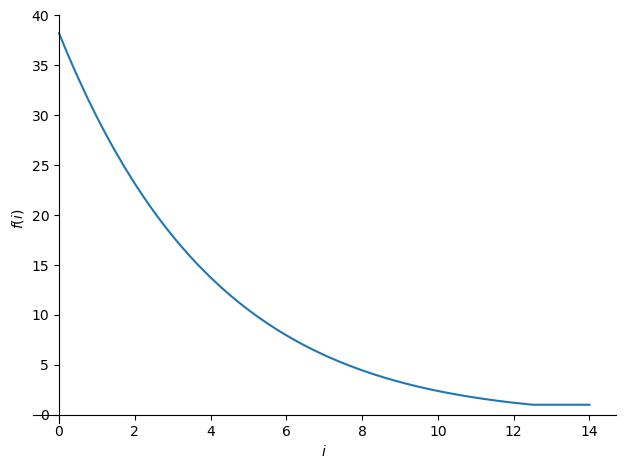

[1.2821173688067196,
 1.2876083994243004,
 1.2939942965222,
 1.3013727876940475,
 1.3098655376353738,
 1.319623980594158,
 1.3308372453625212,
 1.3437430277289266,
 1.3586427057221866,
 1.3759227004943717,
 1.396085254289935,
 1.4197937867385473,
 1.2001175063522251,
 1.0]

In [46]:
# lets answer the recycling at greens and reds vs blues question.

gr_recycling_setup = ([4 * t3quality], recycling * (1 + base_prod + 5 * t3productivity))

inf_up_level = symbols("i")

b_recycling_setup = ([4 * t3quality], recycling * Min(4, 1 + base_prod + 5 * t3productivity + inf_up_level * Rational(1, 10)))

display(loop_input_relative_value(*gr_recycling_setup)[0])
display(simplify(loop_input_relative_value(*b_recycling_setup)[0]))
plot(1/(loop_input_relative_value(*b_recycling_setup)[0]), (inf_up_level, 0, 14))

display([float((1/(loop_input_relative_value(*b_recycling_setup)[0]).subs(inf_up_level, i - 1))/(1/(loop_input_relative_value(*b_recycling_setup)[0]).subs(inf_up_level, i))) for i in range(1, 15)])

In [51]:
#Foundry/module vs Metallugic pack setup

foundry_recycling_setup = ([4 * t3quality, 4 * t3quality], recycling * (1 + base_prod))
module_recycling_setup = ([4 * t3quality, 5 * t3quality], recycling * (1 + base_prod))
science_recycling_setup = ([4 * t3quality], recycling * (1 + base_prod + 4 * t3productivity))

display(float(loop_input_relative_value(*foundry_recycling_setup)[0]))
display(float(loop_input_relative_value(*module_recycling_setup)[0]))
display(float(loop_input_relative_value(*science_recycling_setup)[0]))

0.010195868070890866

0.013223975683621292

0.01426754947857425